# Fairness em Machine Learning: Uma análise baseada na Teoria de Resposta ao Item
Esse notebook apresenta a metodologia no artigo "Fairness em Machine Learning: Uma análise baseada na Teoria de Resposta ao Item".

Este notebook foi projetado para ser executado em ordem. O uso do Google Colab é recomendado para facilidade de instalação dos pacotes.

Os dados gerados pelo artigo estão na pasta do Github. É possível que resultados saiam levemente diferentes em execuções que não utilizem o mesmo conjunto de dados sintéticos, portanto, para fins de robustez, o uso do `synthetic_female_data.csv` é encorajado.

In [3]:
!pip install openml
!pip install rpy2
!pip install catsim
!pip install scikit-posthocs
!pip install sdv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.8 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=4be9c15ce2b74af73818f82adf7badf105995171f2d965e713b09af7b1c0876f
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import random
import numpy as np
import pandas as pd
import copy
import sdv

import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef, auc, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.rinterface import RRuntimeWarning
import warnings
import seaborn as sns

import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import numpy as np
from catsim.irt import icc, inf

import openml

from sklearn.metrics import auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, accuracy_score
warnings.filterwarnings("ignore", category=RRuntimeWarning)

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

if not rpackages.isinstalled('ltm'):
    print('Pacote ltm nao instalado. Instalando...')
    utils.install_packages('ltm')

#Importa o pacore ltm do R
ltm = rpackages.importr('ltm')
pandas2ri.activate()

(as ‘lib’ is unspecified)



Pacote ltm nao instalado. Instalando...



































	‘/tmp/RtmptMmaKy/downloaded_packages’



O dataset escolhido para análise foi o `credit-g`, portanto, vamos pegá-lo do OpenML.

## Funções Auxiliares
Não são realmente necessárias para entendimento, você pode pular essa seção.

In [5]:
CLASSIFIERS = ['RF','GB','BAG','ADA','KNN','DT','SVM','MLP','LDA','LSVM']
GROUPS = ['biased', 'mitigated']
SEXES = ['male', 'female']

In [6]:
def get_all_females(df):
    return df[df['personal_status'].str.contains(r"^female", regex=True)]


def get_all_males(df):
    return df[df['personal_status'].str.contains(r"^male", regex=True)]


def compare_resp(original, pred):
    """Compara as respostas originais (y_test) com as preditas (y_pred)"""
    tmp = []
    for i in range(len(original)):
        if original[i] == pred[i]:
            tmp.append(1)
        else:
            tmp.append(0)
    return tmp


def calcIRT(respMatrix):
  pd.DataFrame.iteritems = pd.DataFrame.items

  data = ltm.tpm(respMatrix)

  par = str(data).split('\n')

  irt_param_matrix = []
  key = 0
  for c,string in enumerate(par):
    if string == 'Coefficients:':
      key= 1
    if key:
      str_list = string.split()
      if str_list == []:
        break
      elif len(str_list) == 4:
        dis = float(str_list[3])
        dif = float(str_list[2])
        gues = float(str_list[1])
        irt_param_matrix.append([dis,dif,gues])

  irt_df = pd.DataFrame(irt_param_matrix, columns=['Dis','Dif','Gues'])
  return irt_df


def calc_ML_metrics(pred_clf,y_test):
  """Calcula as métricas de desempenho dos modelos de ML"""
  dict_metrics = {}

  for clf in pred_clf:
    clf_acc = accuracy_score(y_test,pred_clf[clf])
    clf_f1 = f1_score(y_test,pred_clf[clf])
    clf_precision = precision_score(y_test,pred_clf[clf])
    clf_recall = recall_score(y_test,pred_clf[clf])
    fpr, tpr, threshoulds = roc_curve(y_test,pred_clf[clf])
    clf_auc = auc(fpr,tpr)
    tn, fp, fn, tp = confusion_matrix(y_test,pred_clf[clf]).ravel()
    clf_spe = tn / (tn+fp)


    dict_metrics[clf] = {'acc_score':clf_acc,
                          'f1_score':clf_f1,
                          'precision_score':clf_precision,
                          'recall_score':clf_recall,
                          'auc_score':clf_auc,
                          'specf_score':clf_spe}
  return dict_metrics


def calcIRT(respMatrix):
  """Calcula o IRT"""
  pd.DataFrame.iteritems = pd.DataFrame.items

  data = ltm.tpm(respMatrix)

  par = str(data).split('\n')

  irt_param_matrix = []
  key = 0
  for c,string in enumerate(par):
    if string == 'Coefficients:':
      key= 1
    if key:
      str_list = string.split()
      if str_list == []:
        break
      elif len(str_list) == 4:
        dis = float(str_list[3])
        dif = float(str_list[2])
        gues = float(str_list[1])
        irt_param_matrix.append([dis,dif,gues])

  irt_df = pd.DataFrame(irt_param_matrix, columns=['Dis','Dif','Gues'])
  return irt_df


def plot_IRT_params_box(y_test, item_param_df: pd.DataFrame):
  """Plota os parâmetros do IRT em boxplots"""
  fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(8, 5))
  n_bins = 5
  item_param_text = {'Dis':'Discriminação','Dif':'Dificuldade','Gues':'Adivinhação'}
  minor_itens = []
  major_itens = []
  for c,i in enumerate(y_test):
    if i == 1:
      minor_itens.append(c)
    else:
      major_itens.append(c)

  # Ensure indices are within bounds
  minor_itens = [i for i in minor_itens if i < len(item_param_df)]
  major_itens = [i for i in major_itens if i < len(item_param_df)]

  df_minor = item_param_df.iloc[minor_itens]
  df_major = item_param_df.iloc[major_itens]

  for c,item_p in enumerate(item_param_df.columns):
    counts, edges, bars = axs[c].hist([df_major[item_p],df_minor[item_p]], bins=n_bins,histtype='barstacked', label="Média = {:.3f}\nMediana = {:.3f}\nDesvio = {:.3f}".format(item_param_df[item_p].mean(),
                                                                                                                item_param_df[item_p].median(),
                                                                                                                item_param_df[item_p].std()))
    y_offset = 1
    barras_plotadas = {}
    for bar in axs[c].patches:
      altura_adicional = 0
      if bar.get_x() not in barras_plotadas:
        barras_plotadas[bar.get_x()] = bar.get_height()
      else:
        if abs(barras_plotadas[bar.get_x()] - bar.get_height()) < 4:
          if barras_plotadas[bar.get_x()] < 4:
            altura_adicional = 3
      if bar.get_height() != 0:
        if bar.get_height() <= 4:
          axs[c].text(
              bar.get_x() + bar.get_width() / 2,
              bar.get_height() + bar.get_y() + y_offset + altura_adicional,
              round(bar.get_height()),
              ha='center',
              color='black',
              size=12
          )
        else:
          axs[c].text(
              bar.get_x() + bar.get_width() / 2,
              bar.get_height() + bar.get_y() + y_offset - 4,
              round(bar.get_height()),
              ha='center',
              color='black',
              size=12
          )


    axs[c].set_title(item_param_text[item_p])
    axs[c].title.set_size(18)
    axs[c].tick_params(labelsize=14)
    leg = axs[c].legend(loc='best', shadow=False, markerscale=0, handlelength=0, handletextpad=0, fancybox=True, fontsize=14)
    for item in leg.get_patches():
        item.set_visible(False)

  plt.show()


def plot_IRT_params_3d(item_param_df: pd.DataFrame, y_test):
  """Plota os parâmetros do IRT em 3D"""
  item_param_text = {'Dis':'Discrimination','Dif':'Difficulty','Gues':'Guessing'}

  fig, ax = plt.subplots(subplot_kw={'projection': '3d'},gridspec_kw=dict(top=1, bottom=0, left=0, right=1))
  minor_xs, minor_ys, minor_zs = [], [], []
  major_xs, major_ys, major_zs = [], [], []

  # Ensure indices are within bounds
  valid_indices = [i for i in range(len(y_test)) if i < len(item_param_df)]

  for c in valid_indices:
    if y_test[c] == 1:
      minor_xs.append(item_param_df['Dis'][c])
      minor_ys.append(item_param_df['Dif'][c])
      minor_zs.append(item_param_df['Gues'][c])
    else:
      major_xs.append(item_param_df['Dis'][c])
      major_ys.append(item_param_df['Dif'][c])
      major_zs.append(item_param_df['Gues'][c])

  ax.scatter(major_xs, major_ys, major_zs, marker='o', label='Majority (Negative)')
  ax.scatter(minor_xs, minor_ys, minor_zs, marker='^', label='Minority (Positive)')

  ax.set_xlabel(item_param_text['Dis'])
  ax.set_ylabel(item_param_text['Dif'])
  ax.set_zlabel(item_param_text['Gues'])

  ax.legend(loc='best', shadow=False)
  ax.set_box_aspect(aspect=None, zoom=0.85)

  fig.set_tight_layout(True)
  fig.subplots_adjust(left=-1)
  plt.show()


def plot_model_performance(models, y_true, y_preds):
    """
    Plots subplots with model names, confusion matrices, and performance scores.

    Args:
        models (list): List of model names.
        y_true (list): Ground truth labels.
        y_preds (list): List of predictions from each model.
    """
    n_models = len(models)
    fig, axes = plt.subplots(n_models, 2, figsize=(12, 6 * n_models))

    if n_models == 1:
        axes = [axes]  # Handle single model case.

    for i, (model, y_pred) in enumerate(zip(models, y_preds)):
        metrics = calc_ML_metrics(pred_clf=dict(zip(models, y_preds)), y_test=y_true)
        # Calculate metrics
        acc = metrics[model]['acc_score']
        f1 = metrics[model]['f1_score']
        precision = metrics[model]['precision_score']
        recall = metrics[model]['recall_score']
        auc = metrics[model]['auc_score']
        specf = metrics[model]['specf_score']

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i][0], cbar=False)
        axes[i][0].set_title(f"{model} - Confusion Matrix", fontsize=14)
        axes[i][0].set_xlabel("Predicted", fontsize=12)
        axes[i][0].set_ylabel("Actual", fontsize=12)

        # Performance Metrics
        metrics_text = (f"Accuracy: {acc:.2f}\n"
                        f"F1 Score: {f1:.2f}\n"
                        f"Precision: {precision:.2f}\n"
                        f"Recall: {recall:.2f}\n"
                        f"AUC: {auc:.2f}\n"
                        f"Specificity: {specf:.2f}")

        axes[i][1].text(0.5, 0.5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"))
        axes[i][1].set_title(f"{model} - Performance Metrics", fontsize=14)
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()


def plot_icc(irt_parameters_matrix,cm_instances,model_name,output_dataset,dict_probCorrect,dict_totalScore):
  """Plota as curvas características dos itens"""
  lista_ax = [[0,0],[0,1],[1,1],[1,0]]

  cm_list = ['True Positive','False Positive','True Negative','False Negative']

  cm_dict = {'tp':0, 'fp':1, 'tn':2, 'fn':3}

  fig, axs = plt.subplots(2, 2, figsize=(12, 8))

  for ci,instance_type in enumerate(cm_dict):

    irt_matrix_tmp = np.array([irt_parameters_matrix[i] for i in cm_instances[cm_dict[instance_type]]])

    i = lista_ax[ci][0]
    j = lista_ax[ci][1]

    x = [p for p in np.linspace(-3,3,500)]
    for irt_param in irt_matrix_tmp:

      a = irt_param[0]
      b = irt_param[1]
      c = irt_param[2]
      d = irt_param[3]

      lista1 = [icc(theta=t,a=a,b=b,c=c,d=d) for t in x]

      model=make_interp_spline(x, lista1)

      xs=np.linspace(-3,3,500)
      ys=model(xs)

      if lista1[-1] > lista1[0]:
        axs[i,j].plot(xs, ys,color='b',alpha=0.3,linewidth=0.9)
      else:
        axs[i,j].plot(xs, ys,color='red',alpha=0.3,linewidth=0.9)

    a = [p[0] for p in irt_matrix_tmp]
    b = [p[1] for p in irt_matrix_tmp]
    c = [p[2] for p in irt_matrix_tmp]

    lista1 = [icc(theta=t,a=np.mean(a),b=np.mean(b),c=np.mean(c),d=1) for t in x]
    inf_list = [inf(theta=t,a=np.mean(a),b=np.mean(b),c=np.mean(c),d=1) for t in x]

    model=make_interp_spline(x, lista1)

    xs=np.linspace(-3,3,500)
    ys=model(xs)

    prob_correct = sum(dict_probCorrect[model_name][instance_type])
    prob_perc = (100*prob_correct)/len(a)

    axs[i,j].plot(xs, ys,color='black', label="a = {:.3f}\nb = {:.3f}\nc = {:.3f}\ntotalS = {:.3f}\ninf = {:.3f}\nn = {}".format(np.mean(a),np.mean(b),np.mean(c),
                                                                                                                                     #prob_correct,
                                                                                                                                     dict_totalScore[model_name][instance_type],
                                                                                                                                     np.mean(inf_list),
                                                                                                                                     len(a)))
    axs[i,j].set_title(cm_list[ci])
    axs[i,j].title.set_size(18)

    axs[i,j].plot((0, 0), (0, 1),color='grey', linestyle='dashed',linewidth=0.8)
    axs[i,j].plot((-3, 3), (0.5, 0.5),color='grey', linestyle='dashed',linewidth=0.8)

    leg = axs[i,j].legend(loc='upper right', shadow=False,markerscale=0,handlelength=0, handletextpad=0, fancybox=True, fontsize=14)
    for item in leg.legendHandles:
      item.set_visible(False)


    for ax in axs.flat:
      ax.set_xlabel('Ability', fontsize = 18)
      ax.set_ylabel('Prob. Correct', fontsize = 18)

    for ax in axs.flat:
      ax.label_outer()

    fig.suptitle(model_name+' Item Characteristic Curve', size = 20)

    fig.tight_layout()


def calc_irt_totalScore(resp_vector,prob_correct_vector,dis_vector=None):
  """Calcula o total score do IRT"""
  totalScore = 0
  for c,resp_i in enumerate(resp_vector):
    prob_corret_value = prob_correct_vector[c]
    if resp_i == 1:
      totalScore += prob_corret_value
    else:
      if dis_vector != None:
        if dis_vector[c] > 0:
          prob_corret_value = 1 - prob_corret_value
      else:
        prob_corret_value = 1 - prob_corret_value
      totalScore -= prob_corret_value

  return totalScore


def get_prediction_and_response_matrix(pool_of_models, X_test, y_test):
  prediction_matrix = {}
  response_matrix = {}
  for model in pool_of_models:
    y_pred = pool_of_models[model].predict(X_test)
    prediction_matrix[model] = y_pred
    response_matrix[model] = compare_resp(y_test, y_pred)
  return prediction_matrix, response_matrix


def winsorizing_percentil(df, cols, perc = .1):
  """Método de Retirar Outliers"""
  result = df.copy()

  for feature_name in cols:
    min_value = result[feature_name].quantile(perc)
    max_value = result[feature_name].quantile(1 - perc)

    result[feature_name] = result[feature_name].mask(result[feature_name] > max_value, max_value)
    result[feature_name] = result[feature_name].mask(result[feature_name] < min_value, min_value)
  return result

### Pool de Modelos

In [7]:
# Models Pool

class RF():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = None

    if seed == None:
      self.seed = 42
      self.clf = RandomForestClassifier(random_state = 42)
      self.name = 'RF_std'
    else:
      self.name = 'RF_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'RF_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    criterion = random.choice(['gini','entropy','log_loss'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return n_estimators, criterion, max_features, random_state

  def random_clf(self):
    n_estimators, criterion, max_features, random_state = self.choice_random_param()

    return RandomForestClassifier(n_estimators = n_estimators,
                                  criterion = criterion,
                                  max_features = max_features,
                                  random_state = random_state)

class GB():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'GB_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = GradientBoostingClassifier(random_state = 42)
      self.name = 'GB_std'
    else:
      self.name = 'GB_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'GB_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    criterion = random.choice(['friedman_mse','squared_error'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return n_estimators, criterion, max_features, random_state

  def random_clf(self):
    n_estimators, criterion, max_features, random_state = self.choice_random_param()

    return GradientBoostingClassifier(n_estimators = n_estimators,
                                      criterion = criterion,
                                      max_features = max_features,
                                      random_state = random_state)

class BAG():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'BAG_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = BaggingClassifier(random_state = 42)
      self.name = 'BAG_std'
    else:
      self.name = 'BAG_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'BAG_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    bootstrap = random.choice([True,False])
    random_state = self.seed

    random.seed(None)

    return n_estimators, bootstrap, random_state

  def random_clf(self):
    n_estimators, bootstrap, random_state = self.choice_random_param()

    return BaggingClassifier(n_estimators = n_estimators,
                             bootstrap = bootstrap,
                             random_state = random_state)

class ADA():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'ADA_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = AdaBoostClassifier(algorithm='SAMME',random_state = 42)
      self.name = 'ADA_std'
    else:
      self.name = 'ADA_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'ADA_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    random_state = self.seed

    random.seed(None)

    return n_estimators, random_state

  def random_clf(self):
    n_estimators, random_state = self.choice_random_param()

    return AdaBoostClassifier(n_estimators = n_estimators,
                              algorithm='SAMME',
                              random_state = random_state)

class MLP():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'MLP_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = MLPClassifier(random_state = 42)
      self.name = 'MLP_std'
    else:
      self.name = 'MLP_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'MLP_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    max_iter = random.randint(1,200)
    activation = random.choice(['identity','logistic','tanh','relu'])
    solver = random.choice(['lbfgs','sgd','adam'])
    random_state = self.seed

    random.seed(None)

    return max_iter, activation, solver, random_state

  def random_clf(self):
    max_iter, activation, solver, random_state = self.choice_random_param()

    return MLPClassifier(max_iter = max_iter,
                         activation = activation,
                         solver = solver,
                         random_state = random_state)

class DT():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'DT_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = DecisionTreeClassifier(random_state = 42)
      self.name = 'DT_std'
    else:
      self.name = 'DT_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'DT_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    criterion = random.choice(['gini','entropy','log_loss'])
    splitter = random.choice(['best','random'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return criterion, splitter, max_features, random_state

  def random_clf(self):
    criterion, splitter, max_features, random_state = self.choice_random_param()

    return DecisionTreeClassifier(criterion = criterion,
                                  splitter= splitter,
                                  max_features = max_features,
                                  random_state = random_state)

class KNN():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'KNN_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = KNeighborsClassifier()
      self.name = 'KNN_std'
    else:
      self.name = 'KNN_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'KNN_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_neighbors = random.randint(1,15)
    if (n_neighbors % 2) == 0: # seleciona apenas numeros impares
      n_neighbors += 1

    weights = random.choice(['uniform','distance'])
    algorithm = random.choice(['auto','ball_tree','kd_tree','brute'])

    random.seed(None)

    return n_neighbors, weights, algorithm

  def random_clf(self):
    n_neighbors, weights, algorithm = self.choice_random_param()

    return KNeighborsClassifier(n_neighbors = n_neighbors,
                                weights = weights,
                                algorithm = algorithm)

class SVM():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'SVM_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = SVC(random_state = 42)
      self.name = 'SVM_std'
    else:
      self.name = 'SVM_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'SVM_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    kernel = random.choice(['linear','rbf','sigmoid'])
    gamma = random.choice(['auto','scale'])
    random_state = self.seed

    random.seed(None)

    return kernel, gamma, random_state

  def random_clf(self):
    kernel, gamma, random_state = self.choice_random_param()

    return SVC(kernel = kernel,
               gamma = gamma,
               random_state = random_state)

class LSVM():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'LSVM_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = LinearSVC(random_state = 42)
      self.name = 'LSVM_std'
    else:
      self.name = 'LSVM_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'LSVM_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    loss = random.choice(['hinge','squared_hinge'])
    max_iter = random.randint(800,1000)
    random_state = self.seed

    random.seed(None)

    return loss, max_iter, random_state

  def random_clf(self):
    loss, max_iter, random_state = self.choice_random_param()

    return LinearSVC(loss = loss,
                     max_iter = max_iter,
                     random_state = random_state)

class LDA():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'LDA_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = LinearDiscriminantAnalysis()
      self.name = 'LDA_std'
    else:
      self.name = 'LDA_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'LDA_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    solver = random.choice(['svd','lsqr'])
    if (solver == 'lsqr'):
      shrinkage = random.choice(['auto',None])
    else:
      shrinkage = None

    random.seed(None)

    return solver, shrinkage

  def random_clf(self):
    solver, shrinkage = self.choice_random_param()

    return LinearDiscriminantAnalysis(solver = solver,
                                      shrinkage = shrinkage)

class modelsPool():
  def __init__(self, clf_type, n_models = 10):
    clf_dict = {'RF':RF(),'GB':GB(),'BAG':BAG(),'ADA':ADA(),'KNN':KNN(),'DT':DT(),'SVM':SVM(),'MLP':MLP(),'LDA':LDA(),'LSVM':LSVM()}

    self.vector = []
    for i in range(0,n_models):
      model_tmp = clf_dict[clf_type]
      model_tmp.set_seed(i)
      self.vector.append(copy.deepcopy(model_tmp))

## Processamento dos Dados
Nesta seção os dados do Credit-G são pegos do OpenML e estratificados. Além disso, os preprocessadores são criados e ajustados para o dataset.

In [8]:
# Get data from openML
dataset = openml.datasets.get_dataset('credit-g')
X, y, categorical_indicator, attribute_names = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

No `credit-g`, o dataset não usa as categorias `vacation` na feature `purpose`, nem `female single` na feature `personal_status`. Isso impede a criação de dados sintéticos pelo SDV, portanto, vamos retirar. Veja abaixo como somente essas duas categorias não são utilizadas no dataset inteiro.

In [9]:
from tabulate import tabulate

print("* Unused categories per Column *")

table = {}

for col in X.columns:
  tmp = X[col].value_counts().loc[lambda x: x == 0].index.tolist()
  if len(tmp) > 0:
    table[col] = tmp
  else:
    table[col] = ['None']

df = pd.DataFrame.from_dict(table).transpose()
df.columns = ['Unused Categories']
print(tabulate(df, headers='keys', tablefmt='psql'))

* Unused categories per Column *
+------------------------+---------------------+
|                        | Unused Categories   |
|------------------------+---------------------|
| checking_status        | None                |
| duration               | None                |
| credit_history         | None                |
| purpose                | vacation            |
| credit_amount          | None                |
| savings_status         | None                |
| employment             | None                |
| installment_commitment | None                |
| personal_status        | female single       |
| other_parties          | None                |
| residence_since        | None                |
| property_magnitude     | None                |
| age                    | None                |
| other_payment_plans    | None                |
| housing                | None                |
| existing_credits       | None                |
| job                    | None     

In [10]:
# Retira vacation do CategoricalDtype de `purpose`
X["purpose"] = X["purpose"].astype(
    pd.CategoricalDtype(
        categories=[
            "new car", "used car", "furniture/equipment", "radio/tv",
            "domestic appliance", "repairs", "education",
            "retraining", "business", "other"
        ],
        ordered=True
    )
)

# Retira 'female single' do CategoricalDtype de `personal_status`
X["personal_status"] = X["personal_status"].astype(
    pd.CategoricalDtype(
        categories=[
            'male div/sep', 'female div/dep/mar',
            'male single', 'male mar/wid'
        ],
        ordered=True
    )
)

assert(not 'vacation' in list(X["personal_status"].dtype.categories))
assert(not 'female single' in list(X["personal_status"].dtype.categories))

In [11]:
# Criação de objetos para Pré-processamento
preprocess_X = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_indicator),
        ('num', StandardScaler(), make_column_selector(dtype_include='number')) #ZScore
    ]
)

preprocess_y = LabelEncoder()

preprocess_X.fit(X)
preprocess_y.fit(y)

LabelEncoder()

In [12]:
# Pega todas as instâncias femininas
female_data = {
    'X': get_all_females(X),
    'y': y.loc[get_all_females(X).index]
}

# Preprocessamento dos dados
coded_female_data = {
    'X': preprocess_X.transform(female_data['X']),
    'y': preprocess_y.transform(female_data['y'])
}

## Análise do Credit-G

Esta seção analisa um pouco do dataset escolhido, encontrando as classes minoritárias e majoritárias, além de expor o viés de representação.

In [13]:
y.value_counts()

,count
class,
good,700
bad,300


In [14]:
X['personal_status'].value_counts()

,count
personal_status,
male single,548
female div/dep/mar,310
male mar/wid,92
male div/sep,50


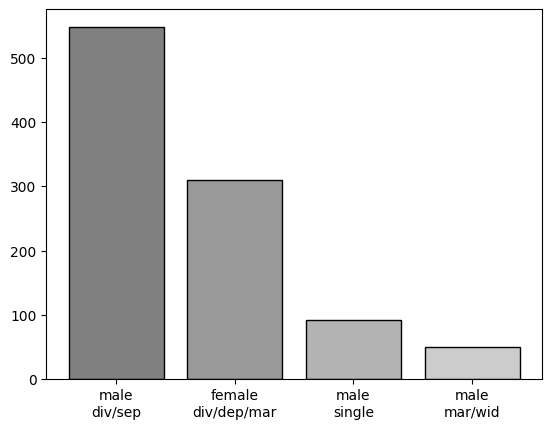

In [15]:
plt.bar(
    ['male\ndiv/sep', 'female\ndiv/dep/mar', 'male\nsingle', 'male\nmar/wid'],
    pd.DataFrame(X["personal_status"].value_counts())["count"].to_numpy(),
    color=['0.5', '0.6', '0.7', '0.8', '0.9'],
    snap=True,
    ec='black'
)
plt.savefig('female-male-ratio.png')

Quantas instâncias femininas e masculina são `good` e quantas são `bad`?

In [16]:
females = get_all_females(pd.concat([X, y], axis=1))
males = get_all_males(pd.concat([X, y], axis=1))

df = {
    'Female': {
        'Good': str(females['class'].value_counts()['good']),
        'Bad': str(females['class'].value_counts()['bad']),
        'Ratio (Bad/Good)': round(females['class'].value_counts()['bad'] / females['class'].value_counts()['good'] * 100, 2),
    },
    'Male': {
        'Good': str(males['class'].value_counts()['good']),
        'Bad': str(males['class'].value_counts()['bad']),
        'Ratio (Bad/Good)': round(males['class'].value_counts()['bad'] / males['class'].value_counts()['good'] * 100, 2),
    }
}

pd.DataFrame.from_dict(df)

,Female,Male
Good,201,499
Bad,109,191
Ratio (Bad/Good),54.23,38.28


## Criação de Dados Sintéticos
Esta seção utiliza todos os dados femininos para criar dados sintéticos. Vamos utilizar o SDV GaussianCopulaSynthesizer, para isso, primeiro é necessário definir os metadados da tabela. Vale lembrar que os dados gerados aqui podem ser diferentes, por serem afetados por certa aleatoriedade. Recomendamos o uso dos dados presentes no arquivo `synthetic_female_data.csv` para fins de comparação com o artigo.

In [18]:
# Se você quiser usar os dados sintéticos gerados pelo artigo, use esse código e pule esta seção
synthetic_female_data = pd.read_csv('synthetic_female_data.csv')
synthetic_female_data = {
    'X': synthetic_female_data.drop('class', axis=1),
    'y': synthetic_female_data['class']
}

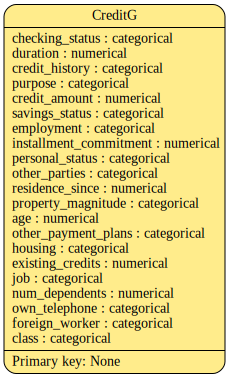

In [ ]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=pd.concat([female_data['X'], female_data['y']], axis=1),
    table_name='CreditG')

# Ajustes nos metadados
metadata.update_column(
    column_name='installment_commitment',
    sdtype='numerical')

metadata.update_column(
    column_name='residence_since',
    sdtype='numerical')

metadata.update_column(
    column_name='existing_credits',
    sdtype='numerical')

metadata.update_column(
    column_name='num_dependents',
    sdtype='numerical')

metadata.visualize()

No nosso dataset com dados femininos, `female_data`, precisamos retirar todas as categorias masculinas do seu CategoricalDtype. Do contrário, a sintetização de dados não vai funcionar.

In [ ]:
# Retira todas as categorias masculinas do CategoricalDtype de female_data e permite criação de dados sintéticos
female_data['X']["personal_status"] = female_data['X']["personal_status"].astype(pd.CategoricalDtype(categories=['female div/dep/mar'], ordered=True))

assert(['female div/dep/mar'] == list(female_data['X']["personal_status"].dtype.categories))

Finalmente vamos gerar o modelo do `GaussianCopulaSynthesizer`, ajustá-los aos nossos dados em `female_data` e gerar as $300$ instâncias femininas.

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(pd.concat([female_data['X'], female_data['y']], axis=1))

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
synthetic_data = synthesizer.sample(
    num_rows=300
)
synthetic_data.to_csv('synthetic_female_data.csv')

synthetic_data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,no checking,13,critical/other existing credit,business,1143.0,<100,>=7,4,female div/dep/mar,none,...,car,20,none,rent,2,skilled,2,none,no,bad
1,no checking,53,no credits/all paid,radio/tv,7161.0,<100,1<=X<4,4,female div/dep/mar,none,...,car,21,none,rent,2,skilled,2,none,no,bad
2,<0,51,critical/other existing credit,new car,3254.0,<100,1<=X<4,2,female div/dep/mar,none,...,car,27,none,rent,2,skilled,2,none,no,bad
3,no checking,13,critical/other existing credit,used car,2203.0,<100,>=7,4,female div/dep/mar,none,...,real estate,20,none,rent,2,skilled,2,none,no,bad
4,<0,27,critical/other existing credit,new car,4545.0,<100,>=7,4,female div/dep/mar,none,...,life insurance,46,none,for free,2,skilled,2,none,no,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,<0,12,no credits/all paid,used car,1699.0,<100,<1,3,female div/dep/mar,none,...,real estate,27,none,rent,2,skilled,2,none,no,good
296,no checking,7,critical/other existing credit,repairs,3603.0,<100,>=7,2,female div/dep/mar,none,...,life insurance,26,none,for free,2,skilled,2,none,no,bad
297,0<=X<200,38,critical/other existing credit,new car,6121.0,<100,>=7,2,female div/dep/mar,none,...,life insurance,21,none,rent,2,skilled,2,none,no,good
298,no checking,16,critical/other existing credit,repairs,1857.0,<100,unemployed,4,female div/dep/mar,none,...,real estate,24,none,rent,2,skilled,2,none,no,good


In [ ]:
synthetic_data['class'].value_counts()

,count
class,
bad,163
good,137


In [ ]:
synthetic_female_data = {
    'X': synthetic_data.drop('class', axis=1),
    'y': synthetic_data['class']
}

Com os dados sintéticos em mãos, podemos realizar o treinamento dos modelos aleatórios com os dados de treino somados aos dados sintéticos.

# Treinamento de Modelos Aleatórios
Vamos realizar o treinamento de duas pools de modelos aleatórios:
* Os enviesados e
* Os mitigados.

Mas vamos começar estratificando os dados.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, shuffle=True, test_size=0.3)

In [20]:
# Concatenação dos dados sintéticos de treino
synthetic_X_train = pd.concat([X_train, synthetic_female_data['X']])
synthetic_y_train = pd.concat([y_train, synthetic_female_data['y']])

`X_train`e `y_train` $\rightarrow$ Treinamento Enviesado


`synthetic_X_train` e `synthetic_y_train` $\rightarrow$ Treinamento Mitigado

Veja como a distribuição dos grupos fica nesse novo grupo sintético e compare com o grupo enviesado anterior.

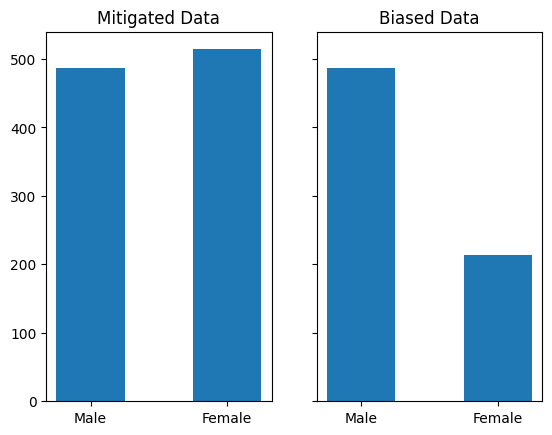

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Mitigated Data Axis
ax1.set_title('Mitigated Data')
ax1.bar(
    ['Male', 'Female'],
    [get_all_males(synthetic_X_train).shape[0], get_all_females(synthetic_X_train).shape[0]],
    width=0.5)

# Biased Data Axis
ax2.set_title('Biased Data')
plt.bar(
    ['Male', 'Female'],
    [get_all_males(X_train).shape[0], get_all_females(X_train).shape[0]],
    width=0.5)

fig.show()

Criado os conjunto de treinamento, vamos gerar os modelos enviesados primeiro.

## Criando os Modelos Aleatórios Enviesados e Mitigados

Este dicionário contém os dados de treinamento codificados para os dois tipos de modelos.

In [22]:
coded_train_data = {
    'biased': {
        'X': preprocess_X.transform(X_train),
        'y': preprocess_y.transform(y_train),
    },
    'mitigated': {
        'X': preprocess_X.transform(synthetic_X_train),
        'y': preprocess_y.transform(synthetic_y_train),
    }
}

Vamos gerar cerca de $20$ modelos diferentes de cada tipo. Isso totaliza cerca de $200$ modelos totais. Vamos armazená-los no dicionário abaixo.

In [23]:
pool_of_random_models = {
    'biased': [],
    'mitigated': [],
}

In [24]:
# Cria pool de modelos aleatórios (ainda não treinados)
classifiers_type = ['RF','GB','BAG','ADA','KNN','DT','SVM','MLP','LDA','LSVM']

for group in ['biased', 'mitigated']:
  for clf_type in classifiers_type:
    list_of_models = modelsPool(clf_type=clf_type, n_models=20)
    for model_i in list_of_models.vector:
      pool_of_random_models[group].append(model_i)

assert pool_of_random_models['biased'] != pool_of_random_models['mitigated']

Agora o treinamento para cada grupo.

In [25]:
# Treina os modelos aleatórios dentro do Pool de modelos
for group in ['biased', 'mitigated']:
  print(f'Training {group} group')
  for model_i in pool_of_random_models[group]:
    model_i.clf.fit(coded_train_data[group]['X'], coded_train_data[group]['y'])

Training biased group


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Training mitigated group


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

## Teste dos Modelos Aleatórios
Nesse teste, vamos salvar o vetor de predição e o vetor de resposta de cada modelo. Usaremos isso para calcular os parâmetros da TRI eventualmente.

In [26]:
prediction_random = {
    'biased': {
        'male': {},
        'female': {},
    },
    'mitigated': {
        'male': {},
        'female': {},
    },
}

response_random = {
    'biased': {
        'male': {},
        'female': {},
    },
    'mitigated': {
        'male': {},
        'female': {},
    },
}

In [27]:
test_data = {
    'male': {
        'X': get_all_males(X_test),
        'y': y_test.loc[get_all_males(X_test).index],
    },
    'female': {
        'X': get_all_females(X_test),
        'y': y_test.loc[get_all_females(X_test).index],
    }
}

In [28]:
for group in ['biased', 'mitigated']:
  print(f'Testing {group} group')
  for sex in ['male', 'female']:
    print(f'* {sex}')
    tmp_prediction = {}
    tmp_response = {}
    for model_i in pool_of_random_models[group]:
      y_pred = model_i.clf.predict(preprocess_X.transform(test_data[sex]['X']))
      tmp_prediction[model_i.name] = y_pred
      tmp_response[model_i.name] = compare_resp(preprocess_y.transform(test_data[sex]['y']), y_pred)

      # Save to structure
      prediction_random[group][sex] = tmp_prediction
      response_random[group][sex] = tmp_response

Testing biased group
* male
* female
Testing mitigated group
* male
* female


In [29]:
assert response_random['mitigated']['male'] != response_random['biased']['male'], 'Mitigated and biased have the same results. Maybe you made a mistake with the variables?'
assert response_random['mitigated']['female'] != response_random['biased']['female'], 'Mitigated and biased have the same results. Maybe you made a mistake with the variables?'

In [30]:
# Save Dictionary

import json
# Convert arrays to list
for key in prediction_random:
  for sex in prediction_random[key]:
    for model in prediction_random[key][sex]:
      prediction_random[key][sex][model] = prediction_random[key][sex][model].tolist()

with open("random_models_response_matrix.json", "w") as file:
    json.dump(response_random, file)

with open("random_models_prediction_matrix.json", "w") as file:
    json.dump(prediction_random, file)

Vamos salvar essas matrizes para não precisarmos repetir o processo novamente, se preciso.

# Calculando os Parâmetros de Item
Agora calcularemos os parâmetros de item baseado na resposta de cada modelo e vamos colocá-los neste dicionário.

In [31]:
# Nones must be overridden with dataframes
irt_params = {
    'biased': {
        'male': None,
        'female': None,
    },
    'mitigated': {
        'male': None,
        'female': None,
    },
}

In [32]:
for group in ['biased', 'mitigated']:
  print(f'* Calculating IRT parameters for {group} group')
  for sex in ['male', 'female']:
    print(sex)
    irt_params[group][sex] = calcIRT(pd.DataFrame(response_random[group][sex]).transpose())

* Calculating IRT parameters for biased group
male
female
* Calculating IRT parameters for mitigated group
male
female


In [33]:
irt_params['mitigated']['male'].describe()

,Dis,Dif,Gues
count,204.000000,204.000000,204.000000
mean,4.930750,-1.171956,0.116642
std,7.979438,2.404715,0.158190
min,-20.822000,-8.985000,0.000000
25%,0.700500,-1.060000,0.011250
50%,3.200500,-0.815000,0.074500
75%,10.245750,-0.517500,0.110000
max,27.272000,8.422000,0.761000


# Avaliação de Modelos Fine Tunados pela TRI
Vamos primeiro escolher os melhores modelos usando *GridSearch* e *CrossValidation* e colocá-los no dicionário. No entanto, porque isso leva muito tempo, os melhores modelos encontrados já estão definido em uma celula mais abaixo.

## Escolha com Grid Search e Cross Validation

In [34]:
pool_of_best_models = {
    'biased': {
          'RF': None,
          'GB': None,
          'BAG': None,
          'ADA': None,
          'KNN': None,
          'DT': None,
          'SVM': None,
          'MLP': None,
          'LDA': None,
          'LSVM': None,
    },

    'mitigated': {
          'RF': None,
          'GB': None,
          'BAG': None,
          'ADA': None,
          'KNN': None,
          'DT': None,
          'SVM': None,
          'MLP': None,
          'LDA': None,
          'LSVM': None,
    }
}

In [35]:
# ┌───────────────────────────────────────────────────────┐
# │ Grid Search and Cross Validation for both groups.     │
# │ Uncomment (select all and press Ctrl + /) to execute. │
# │ It takes REALLY long, so be sure of it.               │
# └───────────────────────────────────────────────────────┘

# from sklearn.model_selection import GridSearchCV

# dict_param_models = {
#     'RF': {'n_estimators':[i for i in range(1,101)],
#            'criterion': ['gini','entropy','log_loss'],
#            'max_features': ['sqrt','log2',None]},
#     'GB': {'n_estimators':[i for i in range(1,101)],
#            'criterion': ['friedman_mse','squared_error'],
#            'max_features': ['sqrt','log2',None]},
#     'BAG': {'n_estimators':[i for i in range(1,101)],
#            'bootstrap': [True,False]},
#     'ADA': {'n_estimators':[i for i in range(1,101)]},
#     'MLP': {'max_iter':[i for i in range(1,201)],
#            'activation': ['identity','logistic','tanh','relu'],
#            'solver': ['lbfgs','sgd','adam']},
#     'DT': {'splitter':['best','random'],
#            'criterion': ['gini','entropy','log_loss'],
#            'max_features': ['sqrt','log2',None]},
#     'KNN': {'n_neighbors':[3,5,7,9,11,13,15],
#            'weights': ['uniform','distance'],
#            'algorithm': ['auto','ball_tree','kd_tree','brute']},
#     'SVM': {'kernel':['linear','rbf','sigmoid'],
#            'gamma': ['auto','scale']},
#     'LSVM': {'loss':['hinge','squared_hinge'],
#            'max_iter': [i for i in range(800,1001)]},
#     'LDA': {'solver':['svd','lsqr'],
#            'shrinkage': ['auto',None]},
# }

# clf_dict = {'RF':RandomForestClassifier(random_state=42),
#             'GB':GradientBoostingClassifier(random_state = 42),
#             'BAG':BaggingClassifier(random_state = 42),
#             'ADA':AdaBoostClassifier(random_state = 42),
#             'KNN':KNeighborsClassifier(),
#             'DT':DecisionTreeClassifier(random_state = 42),
#             'SVM':SVC(random_state = 42),
#             'MLP':MLPClassifier(random_state = 42),
#             'LDA':LinearDiscriminantAnalysis(),
#             'LSVM':LinearSVC(random_state = 42)}

# for group in ['biased', 'mitigated']:
#   print(f'* GridSearchCV for {group} group')
#   for clf in clf_dict:
#     print(clf)
#     pool_of_best_models[group][clf] = GridSearchCV(clf_dict[clf], dict_param_models[clf])
#     pool_of_best_models[group][clf].fit(coded_train_data[group]['X'], coded_train_data[group][y])

# for group in ['biased', 'mitigated']:
#   print('* Best models for {group} group:')
#   for clf in pool_of_best_models[group]:
#     print("\'{}\':{},".format(clf,pool_of_final_models[clf].best_estimator_))

In [36]:
# Melhores modelos já encontrados
pool_of_best_models = {
    'biased': {
          'RF':RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=72,
                        random_state=42),
          'GB':GradientBoostingClassifier(n_estimators=59, random_state=42),
          'BAG':BaggingClassifier(n_estimators=85, random_state=42),
          'ADA':AdaBoostClassifier(n_estimators=97, random_state=42),
          'KNN':KNeighborsClassifier(n_neighbors=15, weights='distance'),
          'DT':DecisionTreeClassifier(criterion='entropy', random_state=42),
          'SVM':SVC(random_state=42),
          'MLP':MLPClassifier(activation='tanh', max_iter=78, random_state=42),
          'LDA':LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
          'LSVM':LinearSVC(max_iter=800, random_state=42),
    },

    'mitigated': {
          'RF':RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=29,
                       random_state=42),
          'GB':GradientBoostingClassifier(max_features='sqrt', n_estimators=96,
                                  random_state=42),
          'BAG':BaggingClassifier(n_estimators=62, random_state=42),
          'ADA':AdaBoostClassifier(n_estimators=42, random_state=42),
          'KNN':KNeighborsClassifier(),
          'DT':DecisionTreeClassifier(criterion='entropy', random_state=42, splitter='random'),
          'SVM':SVC(kernel='sigmoid', random_state=42),
          'MLP':MLPClassifier(activation='tanh', max_iter=177, random_state=42),
          'LDA':LinearDiscriminantAnalysis(),
          'LSVM':LinearSVC(max_iter=800, random_state=42),
    }
}

assert list(pool_of_best_models['biased'].keys()) == ['RF','GB','BAG','ADA','KNN','DT','SVM','MLP','LDA','LSVM']

## Treinamento dos Modelos Encontrados
Agora treinaremos os modelos com seus dados de treino determinados.

In [37]:
for group in ['biased', 'mitigated']:
  print(f'* Training {group} group')
  for model_i in ['RF', 'GB', 'BAG', 'ADA', 'KNN', 'DT', 'SVM', 'MLP', 'LDA', 'LSVM']:
    print(model_i)
    pool_of_best_models[group][model_i].fit(
        coded_train_data[group]['X'],
        coded_train_data[group]['y']
    )

* Training biased group
RF
GB
BAG
ADA
KNN
DT
SVM
MLP


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(


LDA
LSVM
* Training mitigated group
RF
GB
BAG
ADA
KNN
DT
SVM
MLP
LDA
LSVM


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (177) reached and the optimization hasn't converged yet.
  warnings.warn(


## Teste dos Modelos Fine Tunados
As matrizes de resposta e as de predição estarão todas presentes no dicionário abaixo. A chave `concated_and_ordered` armazena a matriz de predição com valores masculinos primeiro, seguidos dos femininos, caso seja necessário.

In [38]:
fine_tuned_prediction_matrix = {
    'biased': {
        'male': {},
        'female': {},
        'concated_and_ordered': {}
    },
    'mitigated': {
        'male': {},
        'female': {},
        'concated_and_ordered': {},
    }
}

fine_tuned_response_matrix = {
    'biased': {
        'male': {},
        'female': {},
        'concated_and_ordered': {}
    },
    'mitigated': {
        'male': {},
        'female': {},
        'concated_and_ordered': {},
    }
}

In [39]:
for sex in ['male', 'female']:
  for group in ['biased', 'mitigated']:
    print(f'Sex: {sex}, Group: {group}')
    pred, resp = get_prediction_and_response_matrix(pool_of_best_models[group], preprocess_X.transform(test_data[sex]['X']), preprocess_y.transform(test_data[sex]['y']))
    fine_tuned_prediction_matrix[group][sex] = pred
    fine_tuned_response_matrix[group][sex] = resp

Sex: male, Group: biased
Sex: male, Group: mitigated
Sex: female, Group: biased
Sex: female, Group: mitigated


In [40]:
# Saving Prediction and Response Matrix of Fine Tuned models
for group in ['biased', 'mitigated']:
  for sex in ['male', 'female']:
    print(f'Sex: {sex}, Group: {group}')
    pd.DataFrame(fine_tuned_prediction_matrix[group][sex]).to_csv(f'fine_tuned_prediction_matrix_{sex}_{group}.csv')
    pd.DataFrame(fine_tuned_response_matrix[group][sex]).to_csv(f'fine_tuned_response_matrix_{sex}_{group}.csv')

Sex: male, Group: biased
Sex: female, Group: biased
Sex: male, Group: mitigated
Sex: female, Group: mitigated


In [41]:
pd.DataFrame(calc_ML_metrics(fine_tuned_prediction_matrix['biased']['male'], preprocess_y.transform(test_data['male']['y'])))

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
acc_score,0.754902,0.764706,0.759804,0.725490,0.735294,0.676471,0.774510,0.745098,0.759804,0.754902
f1_score,0.837662,0.847134,0.842444,0.814570,0.837349,0.782895,0.855346,0.827815,0.839344,0.837662
precision_score,0.801242,0.796407,0.798780,0.793548,0.751351,0.757962,0.795322,0.806452,0.810127,0.801242
recall_score,0.877551,0.904762,0.891156,0.836735,0.945578,0.809524,0.925170,0.850340,0.870748,0.877551
auc_score,0.658074,0.654135,0.656105,0.637666,0.569280,0.571429,0.655567,0.662012,0.672216,0.658074
specf_score,0.438596,0.403509,0.421053,0.438596,0.192982,0.333333,0.385965,0.473684,0.473684,0.438596


In [42]:
pd.DataFrame(calc_ML_metrics(fine_tuned_prediction_matrix['mitigated']['male'], preprocess_y.transform(test_data['male']['y'])))

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
acc_score,0.769608,0.735294,0.764706,0.754902,0.710784,0.661765,0.691176,0.745098,0.764706,0.764706
f1_score,0.845902,0.828025,0.842105,0.841772,0.818462,0.757895,0.792079,0.830065,0.845161,0.846154
precision_score,0.816456,0.778443,0.815287,0.786982,0.747191,0.782609,0.769231,0.798742,0.803681,0.800000
recall_score,0.877551,0.884354,0.870748,0.904762,0.904762,0.734694,0.816327,0.863946,0.891156,0.897959
auc_score,0.684390,0.617615,0.680988,0.636591,0.557644,0.604189,0.592374,0.651271,0.664876,0.659506
specf_score,0.491228,0.350877,0.491228,0.368421,0.210526,0.473684,0.368421,0.438596,0.438596,0.421053


In [43]:
pd.DataFrame(calc_ML_metrics(fine_tuned_prediction_matrix['biased']['female'], preprocess_y.transform(test_data['female']['y'])))

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
acc_score,0.718750,0.718750,0.677083,0.760417,0.697917,0.593750,0.729167,0.708333,0.718750,0.708333
f1_score,0.802920,0.805755,0.766917,0.829630,0.800000,0.688000,0.814286,0.781250,0.787402,0.781250
precision_score,0.743243,0.736842,0.728571,0.777778,0.707317,0.693548,0.740260,0.769231,0.781250,0.769231
recall_score,0.873016,0.888889,0.809524,0.888889,0.920635,0.682540,0.904762,0.793651,0.793651,0.793651
auc_score,0.648629,0.641414,0.616883,0.702020,0.596681,0.553391,0.649351,0.669553,0.684704,0.669553
specf_score,0.424242,0.393939,0.424242,0.515152,0.272727,0.424242,0.393939,0.545455,0.575758,0.545455


In [44]:
pd.DataFrame(calc_ML_metrics(fine_tuned_prediction_matrix['mitigated']['female'], preprocess_y.transform(test_data['female']['y'])))

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
acc_score,0.645833,0.708333,0.656250,0.677083,0.718750,0.531250,0.625000,0.760417,0.718750,0.718750
f1_score,0.746269,0.791045,0.755556,0.759690,0.805755,0.621849,0.689655,0.827068,0.784000,0.784000
precision_score,0.704225,0.746479,0.708333,0.742424,0.736842,0.660714,0.754717,0.785714,0.790323,0.790323
recall_score,0.793651,0.841270,0.809524,0.777778,0.888889,0.587302,0.634921,0.873016,0.777778,0.777778
auc_score,0.578644,0.647908,0.586580,0.631313,0.641414,0.505772,0.620491,0.709235,0.691919,0.691919
specf_score,0.363636,0.454545,0.363636,0.484848,0.393939,0.424242,0.606061,0.545455,0.606061,0.606061


Vamos calcular também os scores das métricas clássicas. Elas são importantes para avaliação e seu `acc_score` será usado como habilidade estimada no cálculo dos $θ$s.

In [45]:
# Dicionário para as Métricas
ML_Scores = {
    'mitigated': {
        'male': None,
        'female': None,
    },
    'biased': {
        'male': None,
        'female': None,
    }
}

In [46]:
# Calculando as Métricas e colocando no Dicionário
for group in GROUPS:
  for sex in SEXES:
    print(group, sex)
    ML_Scores[group][sex] = pd.DataFrame(calc_ML_metrics(fine_tuned_prediction_matrix[group][sex], preprocess_y.transform(test_data[sex]['y']))).transpose()

biased male
biased female
mitigated male
mitigated female


In [47]:
# Salvando Métricas em CSV
for group in GROUPS:
  for sex in SEXES:
    print(group, sex)
    ML_Scores[group][sex].to_csv(f'classic_metrics_{sex}_{group}.csv')

biased male
biased female
mitigated male
mitigated female


## Calculando True e Total Scores

In [48]:
from catsim.estimation import NumericalSearchEstimator # This line should be added to import the class

def adjust_parameter_matrix(irt_parameters):
  return np.append(irt_parameters.to_numpy(), np.ones((len(irt_parameters.to_numpy()), 1)), axis=1)

def calculate_theta(irt_parameters_matrix, reponse_matrix, ML_Scores):
  """Use a função acima no irt_parameters_matrix"""
  dict_theta_all_instances = {}
  batch_size = 2

  dif_vector = [(c,i[0]) for c,i in enumerate(irt_parameters_matrix)]
  dif_sort = sorted(dif_vector, key=lambda tup: tup[1])

  qtd = len(dif_sort)//batch_size

  for clf in reponse_matrix:
    print(clf)
    adm_all_items = [i[0] for i in dif_sort]

    e_theta = ML_Scores['acc_score'][clf]

    r_vector_all = [True if reponse_matrix[clf][dif_i[0]] == 1 else False for dif_i in dif_sort]

    for p in range(1,batch_size+1):

      adm_items = adm_all_items[:qtd]
      adm_all_items = adm_all_items[qtd:]

      r_vector = r_vector_all[:qtd]
      r_vector_all = r_vector_all[qtd:]

      if p == batch_size:
        adm_items += adm_all_items
        r_vector += r_vector_all

      new_theta = NumericalSearchEstimator().estimate(items=irt_parameters_matrix,
                                                      administered_items= adm_items,
                                                      response_vector=r_vector,
                                                      est_theta=e_theta)
      e_theta = new_theta

    dict_theta_all_instances[clf] = new_theta
  return dict_theta_all_instances
  ...

In [49]:
ML_Scores['biased']['male']

,acc_score,f1_score,precision_score,recall_score,auc_score,specf_score
RF,0.754902,0.837662,0.801242,0.877551,0.658074,0.438596
GB,0.764706,0.847134,0.796407,0.904762,0.654135,0.403509
BAG,0.759804,0.842444,0.798780,0.891156,0.656105,0.421053
ADA,0.725490,0.814570,0.793548,0.836735,0.637666,0.438596
KNN,0.735294,0.837349,0.751351,0.945578,0.569280,0.192982
DT,0.676471,0.782895,0.757962,0.809524,0.571429,0.333333
SVM,0.774510,0.855346,0.795322,0.925170,0.655567,0.385965
MLP,0.745098,0.827815,0.806452,0.850340,0.662012,0.473684
LDA,0.759804,0.839344,0.810127,0.870748,0.672216,0.473684
LSVM,0.754902,0.837662,0.801242,0.877551,0.658074,0.438596


In [50]:
ML_Scores['mitigated']['male']

,acc_score,f1_score,precision_score,recall_score,auc_score,specf_score
RF,0.769608,0.845902,0.816456,0.877551,0.684390,0.491228
GB,0.735294,0.828025,0.778443,0.884354,0.617615,0.350877
BAG,0.764706,0.842105,0.815287,0.870748,0.680988,0.491228
ADA,0.754902,0.841772,0.786982,0.904762,0.636591,0.368421
KNN,0.710784,0.818462,0.747191,0.904762,0.557644,0.210526
DT,0.661765,0.757895,0.782609,0.734694,0.604189,0.473684
SVM,0.691176,0.792079,0.769231,0.816327,0.592374,0.368421
MLP,0.745098,0.830065,0.798742,0.863946,0.651271,0.438596
LDA,0.764706,0.845161,0.803681,0.891156,0.664876,0.438596
LSVM,0.764706,0.846154,0.800000,0.897959,0.659506,0.421053


In [51]:
theta = {
    'biased': {
        'male': None,
        'female': None,
    },
    'mitigated': {
        'male': None,
        'female': None,
    }
}

for group in ['biased', 'mitigated']:
  for sex in ['male', 'female']:
    print(group, sex)
    theta[group][sex] = calculate_theta(
        adjust_parameter_matrix(irt_params[group][sex]),
        fine_tuned_response_matrix[group][sex],
        ML_Scores[group][sex]
    )

biased male
RF
GB
BAG
ADA
KNN
DT
SVM
MLP
LDA
LSVM
biased female
RF
GB
BAG
ADA
KNN
DT
SVM
MLP
LDA
LSVM
mitigated male
RF
GB
BAG
ADA
KNN
DT
SVM
MLP
LDA
LSVM
mitigated female
RF
GB
BAG


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2290: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2291: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2289: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2288: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2289: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)


ADA
KNN
DT
SVM
MLP
LDA
LSVM


## Calculando Probabilidade de Acerto

In [52]:
from catsim.irt import icc_hpc
def calculate_prob_correct(theta, irt_parameters_matrix):
  prob_correct = {}
  for clf in theta:
    prob_correct[clf] = list(icc_hpc(theta[clf], irt_parameters_matrix))
  return prob_correct

In [53]:
prob_correct = {
    'biased': {
        'male': None,
        'female': None,
    },
    'mitigated': {
        'male': None,
        'female': None,
    }
}

for group in ['biased', 'mitigated']:
  for sex in ['male', 'female']:
    print(group, sex)
    prob_correct[group][sex] = pd.DataFrame(calculate_prob_correct(theta[group][sex], adjust_parameter_matrix(irt_params[group][sex])))

biased male
biased female
mitigated male
mitigated female


In [54]:
prob_correct['mitigated']['female']

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
0,0.016238,0.007978,0.016639,0.002711,0.026294,0.026667,0.010018,0.013552,0.000009,0.000009
1,0.562373,0.404000,0.567801,0.205308,0.665674,0.668528,0.454025,0.521874,0.001583,0.001583
2,0.031210,0.015415,0.031973,0.005246,0.050148,0.050843,0.019336,0.026098,0.000017,0.000017
3,0.972633,0.986958,0.971939,0.995875,0.955484,0.954860,0.983425,0.977287,0.999992,0.999992
4,0.969508,0.986091,0.968693,0.995925,0.949268,0.948530,0.982058,0.974952,0.999995,0.999995
...,...,...,...,...,...,...,...,...,...,...
91,0.571434,0.462002,0.575150,0.306647,0.643117,0.645143,0.497080,0.543740,0.013132,0.013132
92,1.000000,1.000000,1.000000,1.000000,0.983896,0.964863,1.000000,1.000000,1.000000,1.000000
93,0.985672,0.999440,0.983994,0.999996,0.880997,0.873965,0.998417,0.993708,1.000000,1.000000
94,0.917815,1.000000,0.902331,1.000000,0.874000,0.874000,0.999999,0.997425,1.000000,1.000000


In [55]:
prob_correct['mitigated']['male']

,RF,GB,BAG,ADA,KNN,DT,SVM,MLP,LDA,LSVM
0,0.501429,0.758282,0.456775,7.968737e-01,0.521379,0.291811,0.503748,0.441076,9.999911e-01,9.632408e-01
1,0.999999,1.000000,0.999987,1.000000e+00,1.000000,0.756794,0.999999,0.999969,1.000000e+00,1.000000e+00
2,0.979329,0.999818,0.956840,9.999280e-01,0.985162,0.518325,0.980108,0.944209,1.000000e+00,1.000000e+00
3,0.999998,1.000000,0.999978,1.000000e+00,0.999999,0.816614,0.999998,0.999952,1.000000e+00,1.000000e+00
4,0.999969,1.000000,0.999857,1.000000e+00,0.999984,0.931175,0.999972,0.999753,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
199,0.999994,1.000000,0.999960,1.000000e+00,0.999997,0.935472,0.999994,0.999923,1.000000e+00,1.000000e+00
200,0.279841,0.060292,0.341424,4.324334e-02,0.254789,0.626610,0.276852,0.364872,5.378975e-09,2.339450e-03
201,0.048851,0.002158,0.078571,1.166773e-03,0.039394,0.402220,0.047649,0.092678,7.772284e-16,6.423554e-06
202,0.000722,0.000001,0.001948,4.344327e-07,0.000464,0.100646,0.000686,0.002772,5.873296e-31,1.616096e-11


## Cálculo do True Score

In [56]:
types = ['biased', 'mitigated']
sexes = ['male', 'female']
classifiers = ['RF', 'GB', 'BAG', 'ADA', 'KNN', 'DT', 'SVM', 'MLP', 'LDA', 'LSVM']

TrueScores = {
    'biased': {
        'male': {},
        'female': {},
    },
    'mitigated': {
        'male': {},
        'female': {},
    }
}

for group in ['biased', 'mitigated']:
  for sex in ['male', 'female']:
    for clf in classifiers:
      # male_and_female = np.array(
      #     [*prob_correct[group]['male'][clf], *prob_correct[group]['female'][clf]]
      # )
      # TrueScores[group][sex][clf] = sum(male_and_female) / len(male_and_female) * 100
      TrueScores[group][sex][clf] = sum(prob_correct[group][sex][clf]) / len(prob_correct[group][sex][clf])

    TrueScores[group][sex] = pd.DataFrame.from_dict(TrueScores[group][sex], orient='index', columns=['True Score'])

## Cálculo do Total Score

In [57]:
def calc_irt_totalScore(resp_vector, prob_correct_vector, dis_vector=None):
  totalScore = 0
  for c, resp_i in enumerate(resp_vector):
    prob_corret_value = prob_correct_vector[c]

    if resp_i == 1:
      totalScore += prob_corret_value
    else:
      if dis_vector != None:
        if dis_vector[c] > 0:
          prob_corret_value = 1 - prob_corret_value
      else:
        prob_corret_value = 1 - prob_corret_value
      totalScore -= prob_corret_value

  return totalScore

In [58]:
types = ['biased', 'mitigated']
classifiers = ['RF', 'GB', 'BAG', 'ADA', 'KNN', 'DT', 'SVM', 'MLP', 'LDA', 'LSVM']

TotalScore = {
    'biased': {
        'male': {},
        'female': {},
    },
    'mitigated': {
        'male': {},
        'female': {},
    }
}

for group in ['biased', 'mitigated']:
  for sex in ['male', 'female']:
    for clf in classifiers:
      TotalScore[group][sex][clf] = calc_irt_totalScore(
          fine_tuned_response_matrix[group][sex][clf], np.array(prob_correct[group][sex][clf])
      ) / len(fine_tuned_response_matrix[group][sex][clf])# * 100
    TotalScore[group][sex] = pd.DataFrame.from_dict(TotalScore[group][sex], orient='index', columns=['Total Score'])

In [59]:
pd.concat([TrueScores['biased']['male'], TotalScore['biased']['male']], axis=1)

,True Score,Total Score
RF,0.725520,0.480422
GB,0.740064,0.504770
BAG,0.730433,0.490237
ADA,0.744323,0.469813
KNN,0.736670,0.471965
DT,0.690714,0.367185
SVM,0.752767,0.527277
MLP,0.768965,0.514063
LDA,0.768663,0.528467
LSVM,0.768535,0.523437


In [60]:
pd.concat([TrueScores['mitigated']['male'], TotalScore['mitigated']['male']], axis=1)

,True Score,Total Score
RF,0.739193,0.508801
GB,0.755724,0.491018
BAG,0.735273,0.499979
ADA,0.757790,0.512692
KNN,0.740796,0.451580
DT,0.693437,0.355202
SVM,0.739386,0.430563
MLP,0.733724,0.478822
LDA,0.767628,0.532334
LSVM,0.764764,0.529470


In [61]:
pd.concat([TrueScores['biased']['female'], TotalScore['biased']['female']], axis=1)

,True Score,Total Score
RF,0.430031,0.148781
GB,0.430031,0.148781
BAG,0.430031,0.107115
ADA,0.700115,0.460532
KNN,0.430031,0.127948
DT,0.430031,0.023781
SVM,0.684907,0.414073
MLP,0.711180,0.419514
LDA,0.711098,0.429848
LSVM,0.711180,0.419514


In [62]:
pd.concat([TrueScores['mitigated']['female'], TotalScore['mitigated']['female']], axis=1)

,True Score,Total Score
RF,0.674255,0.320088
GB,0.692699,0.401032
BAG,0.674007,0.330257
ADA,0.700532,0.377616
KNN,0.672797,0.391547
DT,0.670559,0.201809
SVM,0.687980,0.312980
MLP,0.678085,0.438502
LDA,0.720806,0.439556
LSVM,0.720806,0.439556


# Resultados
A partir dos dados gerados, podemos criar alguns plots interessantes.

## Parâmetros de Item

In [63]:
def plot_IRT_params_box(y_test, item_param_df: pd.DataFrame):
  """Plota os parâmetros do IRT em boxplots"""
  fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(8, 5))
  n_bins = 5
  item_param_text = {'Dis':'Discriminação','Dif':'Dificuldade','Gues':'Adivinhação'}
  minor_itens = []
  major_itens = []
  for c,i in enumerate(y_test):
    if i == 1:
      minor_itens.append(c)
    else:
      major_itens.append(c)

  # Ensure indices are within bounds
  minor_itens = [i for i in minor_itens if i < len(item_param_df)]
  major_itens = [i for i in major_itens if i < len(item_param_df)]

  df_minor = item_param_df.iloc[minor_itens]
  df_major = item_param_df.iloc[major_itens]

  for c,item_p in enumerate(item_param_df.columns):
    counts, edges, bars = axs[c].hist([df_major[item_p],df_minor[item_p]], bins=n_bins,histtype='barstacked', label="Média = {:.3f}\nMediana = {:.3f}\nDesvio = {:.3f}".format(item_param_df[item_p].mean(),
                                                                                                                item_param_df[item_p].median(),
                                                                                                                item_param_df[item_p].std()))
    y_offset = 1
    barras_plotadas = {}
    for bar in axs[c].patches:
      altura_adicional = 0
      if bar.get_x() not in barras_plotadas:
        barras_plotadas[bar.get_x()] = bar.get_height()
      else:
        if abs(barras_plotadas[bar.get_x()] - bar.get_height()) < 4:
          if barras_plotadas[bar.get_x()] < 4:
            altura_adicional = 3
      if bar.get_height() != 0:
        if bar.get_height() <= 4:
          axs[c].text(
              bar.get_x() + bar.get_width() / 2,
              bar.get_height() + bar.get_y() + y_offset + altura_adicional,
              round(bar.get_height()),
              ha='center',
              color='black',
              size=12
          )
        else:
          axs[c].text(
              bar.get_x() + bar.get_width() / 2,
              bar.get_height() + bar.get_y() + y_offset - 4,
              round(bar.get_height()),
              ha='center',
              color='black',
              size=12
          )


    axs[c].set_title(item_param_text[item_p])
    axs[c].title.set_size(18)
    axs[c].tick_params(labelsize=14)
    leg = axs[c].legend(loc='best', shadow=False, markerscale=0, handlelength=0, handletextpad=0, fancybox=True, fontsize=14)
    for item in leg.get_patches():
        item.set_visible(False)

  plt.show()


In [64]:
irt_param_winsorizing = irt_params.copy()
for tipo in ['biased','mitigated']:
  for gen in ['male','female']:
    irt_param_winsorizing[tipo][gen] = winsorizing_percentil(irt_params[tipo][gen], ['Dis', 'Dif'])

### Boxplots

In [65]:
def cria_box_plot(a_params, b_params, c_params, title):
  df = pd.DataFrame({
      'Discriminação': a_params,  # Pode ter valores negativos
      'Dificuldade': b_params,  # Geralmente positivo
      'Adivinhação': c_params  # Próximo de zero
  })

  # Criar subplots lado a lado
  fig, axes = plt.subplots(1, 3, figsize=(6, 5))  # 1 linha, 3 colunas

  #fig.suptitle("Parâmetros do Item - "+title, fontsize=14, fontweight='bold')

  # Listando os parâmetros e títulos correspondentes
  parametros = ['Dificuldade', 'Discriminação', 'Adivinhação']
  cores = ['lightblue', 'lightgreen', 'lightcoral']

  # Criando um box plot para cada parâmetro
  for i, parametro in enumerate(parametros):
      sns.boxplot(y=df[parametro], ax=axes[i], color=cores[i])  # Box plot individual
      axes[i].set_title(f"{parametro}", fontsize=12)  # Título do subplot
      axes[i].set_ylabel("", fontsize=10)

  # Ajusta o layout para melhor visualização
  plt.tight_layout()
  plt.show()


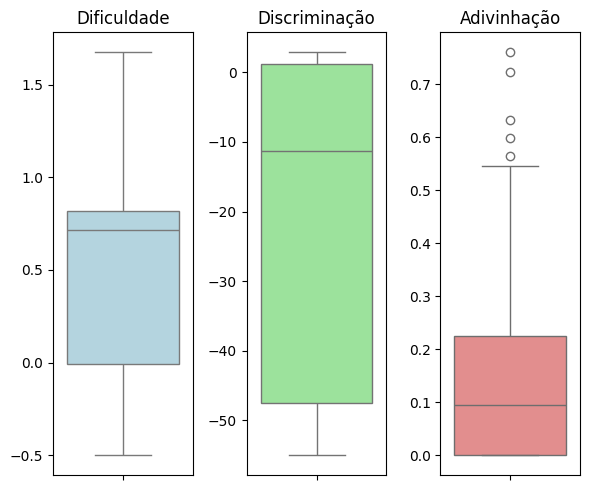

In [66]:
param_to_plot = irt_param_winsorizing['biased']['female']
cria_box_plot(param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Feminino Enviesado')

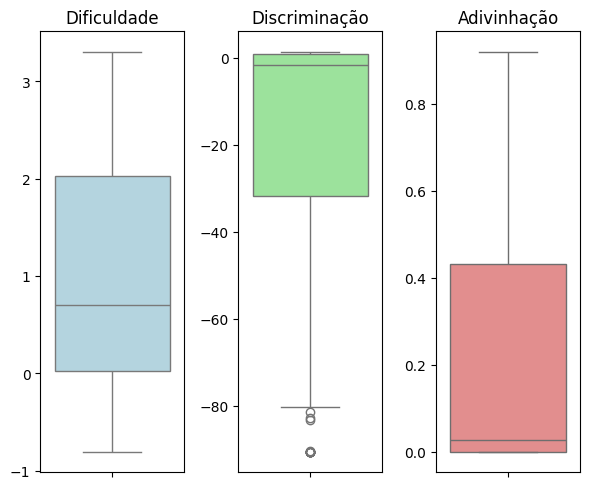

In [67]:
param_to_plot = irt_param_winsorizing['mitigated']['female']
cria_box_plot(param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Feminino Mitigado')

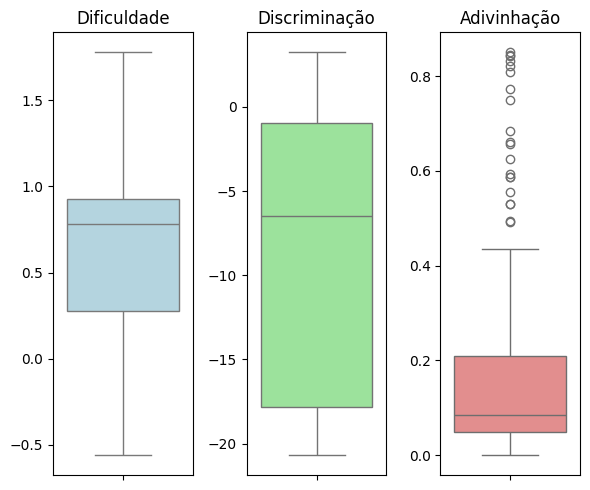

In [68]:
param_to_plot = irt_param_winsorizing['biased']['male']
cria_box_plot(param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Masculino Enviesado')

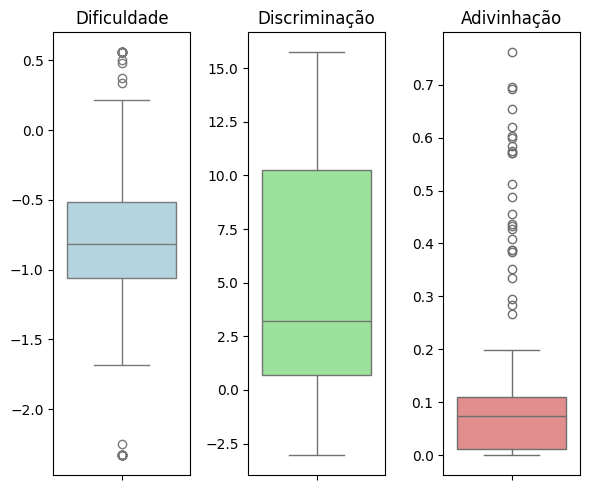

In [69]:
param_to_plot = irt_param_winsorizing['mitigated']['male']
cria_box_plot(param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Masculino Mitigado')

### Histogramas

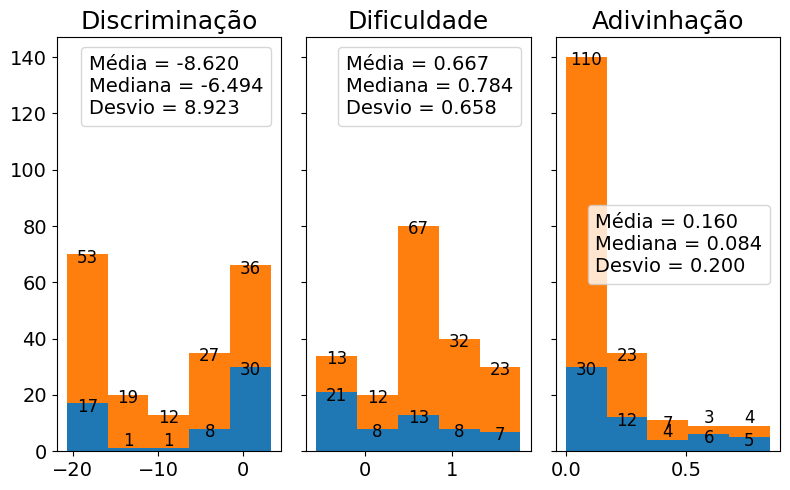

In [70]:
plot_IRT_params_box(preprocess_y.transform(test_data['male']['y']), irt_param_winsorizing['biased']['male'])

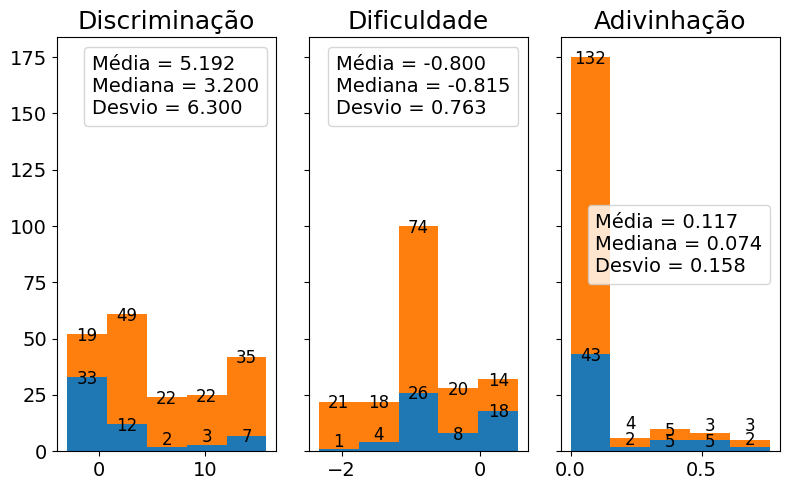

In [71]:
plot_IRT_params_box(preprocess_y.transform(test_data['male']['y']), irt_param_winsorizing['mitigated']['male'])

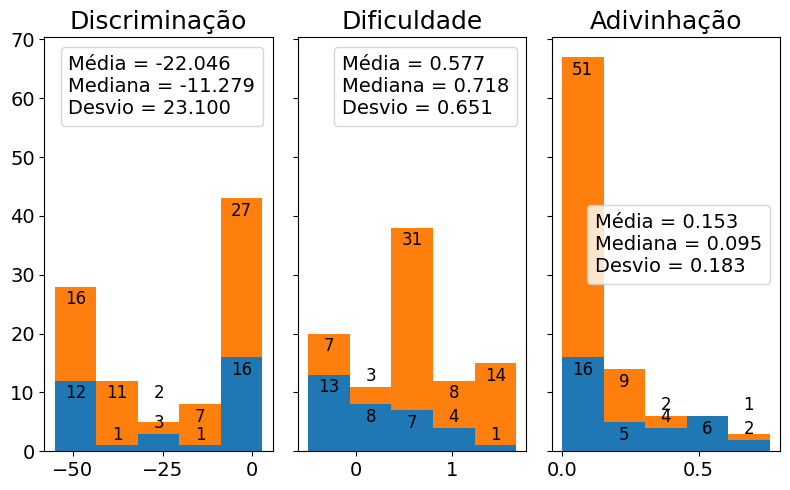

In [72]:
plot_IRT_params_box(preprocess_y.transform(test_data['female']['y']), irt_param_winsorizing['biased']['female'])

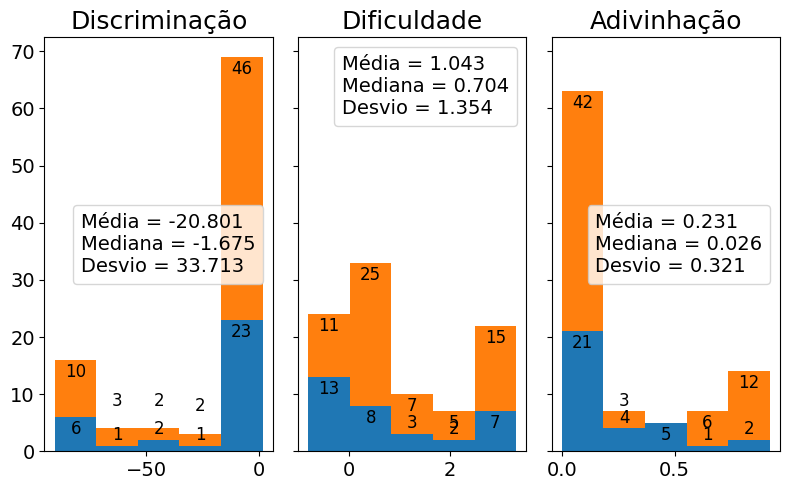

In [73]:
plot_IRT_params_box(preprocess_y.transform(test_data['female']['y']), irt_param_winsorizing['mitigated']['female'])

### Distribuição Espacial

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


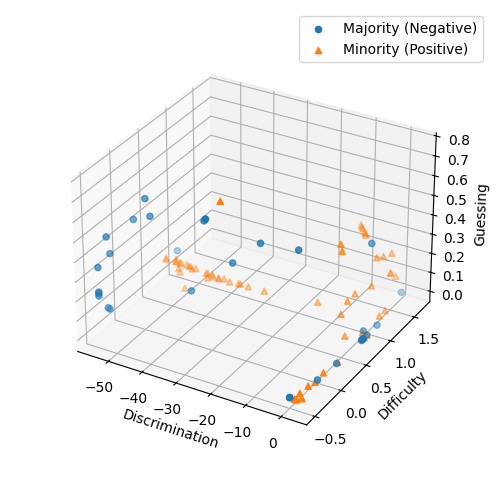

In [74]:
plot_IRT_params_3d(irt_param_winsorizing['biased']['female'], preprocess_y.transform(test_data['female']['y']))

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


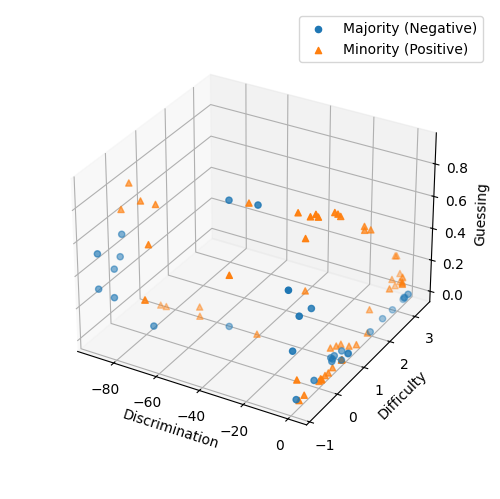

In [75]:
plot_IRT_params_3d(irt_param_winsorizing['mitigated']['female'], preprocess_y.transform(test_data['female']['y']))

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


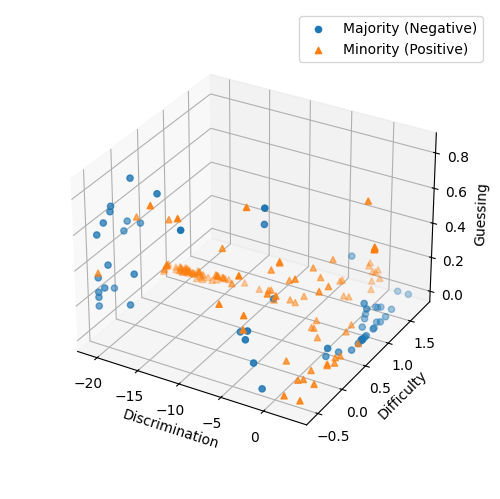

In [76]:
plot_IRT_params_3d(irt_param_winsorizing['biased']['male'], preprocess_y.transform(test_data['male']['y']))

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


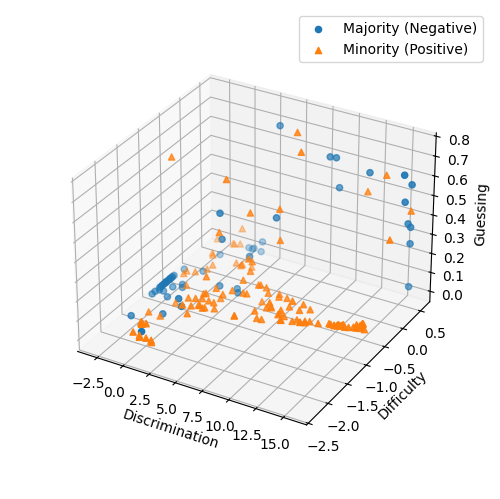

In [77]:
plot_IRT_params_3d(irt_param_winsorizing['mitigated']['male'], preprocess_y.transform(test_data['male']['y']))

### CCIs (ICCs)

In [81]:
from scipy.special import expit
def plot_icc(min_theta, max_theta, a_params, b_params, c_params, title):
  # Definir a faixa de proficiência (theta)
  theta = np.linspace(min_theta, max_theta, 100)
  num_itens = len(a_params)

  # Criar o gráfico
  plt.figure(figsize=(8, 5))

  # Plotar todas as ICCs
  for i in range(len(a_params)):
      P = c_params[i] + (1 - c_params[i]) * expit(a_params[i] * (theta - b_params[i]))  # Modelo 3PL
      if a_params[i] < 0:
        plt.plot(theta, P, color='red', alpha=0.3, linewidth=0.8)
      else:
        plt.plot(theta, P, color='blue', alpha=0.3, linewidth=0.8)  # Linhas azul claras para os itens


  # Destacar um item específico (por exemplo, o primeiro)
  # P_destacado = c_params[0] + (1 - c_params[0]) * expit(a_params[0] * (theta - b_params[0]))
  # plt.plot(theta, P_destacado, color='black', linewidth=2)  # Linha preta destacada

  # Destacar a media dos parametros de item
  a_media = np.mean(a_params)
  b_media = np.mean(b_params)
  c_media = np.mean(c_params)

  P_destacado = c_params[0] + (1 - c_media) * expit(a_media * (theta - b_media))
  plt.plot(theta, P_destacado, color='black', linewidth=2)  # Linha preta destacada

  # Adicionar informações do item destacado
  plt.text(min_theta, 0.8, f"a = {a_media:.3f}\nb = {b_media:.3f}\nc = {c_media:.3f}\nn = {num_itens}",
          fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

  # Adicionar linhas de referência
  plt.axhline(y=0.5, color='gray', linestyle="--", alpha=0.7)
  plt.axvline(x=b_params[0], color='gray', linestyle=":", alpha=0.7)

  # Configurações do gráfico
  plt.xlabel("Proficiência (θ)")
  plt.ylabel("Probabilidade de acerto")
  #plt.title(title)
  plt.grid(True)

  # Exibir o gráfico
  plt.show()

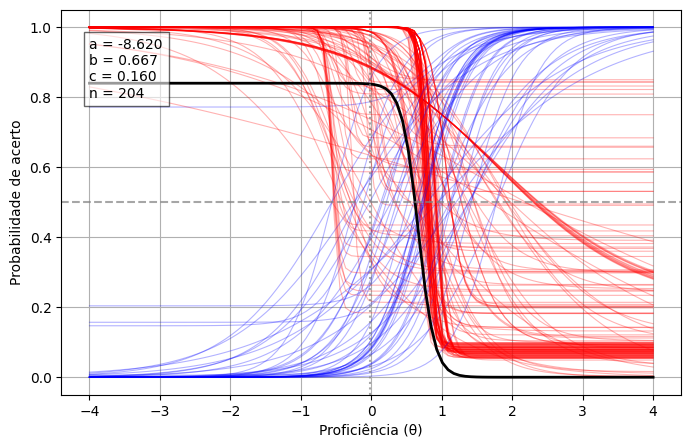

In [82]:
param_to_plot = irt_params['biased']['male']
plot_icc(-4, 4, param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Masculino Enviesado')

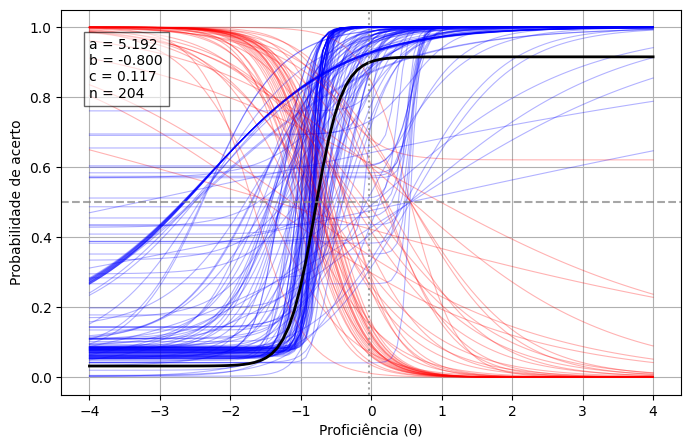

In [83]:
param_to_plot = irt_params['mitigated']['male']
plot_icc(-4, 4, param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Masculino Mitigado')

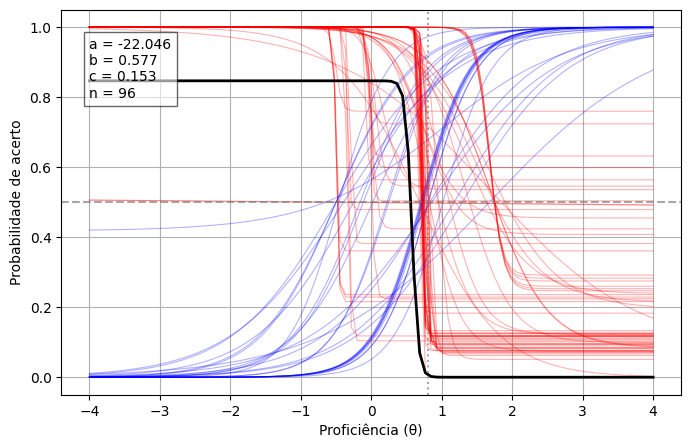

In [84]:
param_to_plot = irt_params['biased']['female']
plot_icc(-4, 4, param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Feminino Enviesado')

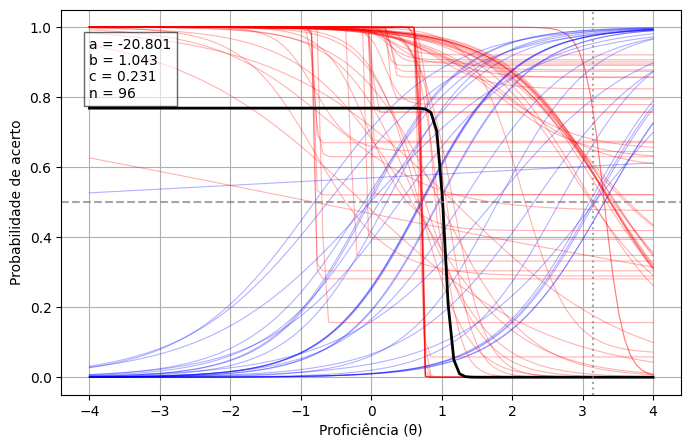

In [85]:
param_to_plot = irt_params['mitigated']['female']
plot_icc(-4, 4, param_to_plot['Dis'].to_numpy(), param_to_plot['Dif'].to_numpy(), param_to_plot['Gues'].to_numpy(), 'Feminino Mitigado')

## Scores dos Modelos

### Radar Charts

In [86]:
from math import pi
def plot_radar_chart(df):

  df = df.reset_index()
  df.rename(columns={'index': 'Modelo'}, inplace=True)
  df.set_index("Modelo", inplace=True)

  # Dicionário com os novos nomes
  novo_nomes = {'acc_score': 'Acc', 'precision_score': 'Prec.',
                'recall_score': 'Recall', 'auc_score': 'AUC', 'specf_score':'Spec.', 'f1_score':'F1'}
  df.rename(columns=novo_nomes, inplace=True)

  categorias = list(df.columns)
  num_vars = len(categorias)

  angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
  angles += angles[:1]  # Fechar o gráfico

  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

  for modelo, row in df.iterrows():
      values = row.tolist()
      values += values[:1]  # Fechar o gráfico
      ax.plot(angles, values, linewidth=1, linestyle="solid", label=modelo)
      #ax.fill(angles, values, alpha=0.2)

  # Adicionar rótulos com os valores máximos para cada métrica
  for i, categoria in enumerate(categorias):
      max_idx = df[categoria].idxmax()
      max_value = df[categoria].max()
      angle = angles[i]
      ax.text(angle, max_value + 0.02, f"{max_idx}: {max_value:.2f}", horizontalalignment='center', fontsize=10, color='black')

  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(categorias)
  plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
  plt.show()

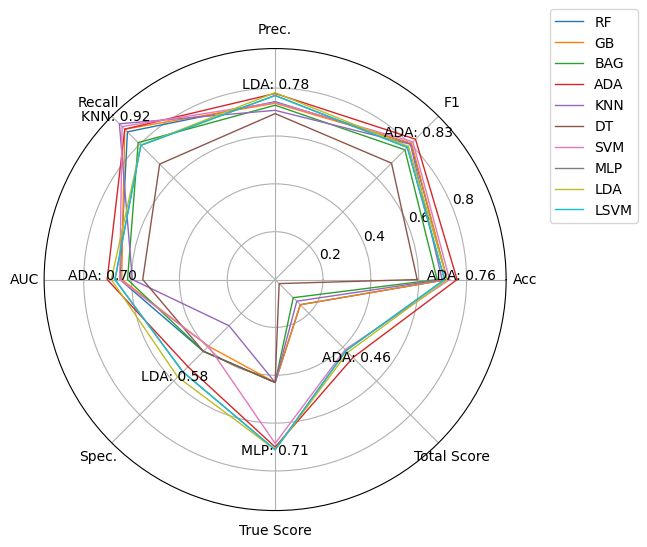

In [87]:
plot_radar_chart(pd.concat([ML_Scores['biased']['female'],TrueScores['biased']['female'], TotalScore['biased']['female']], axis=1))

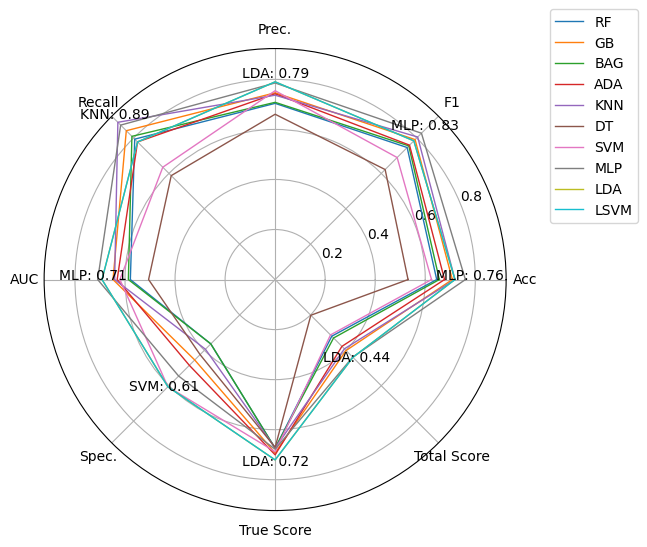

In [88]:
plot_radar_chart(pd.concat([ML_Scores['mitigated']['female'],TrueScores['mitigated']['female'], TotalScore['mitigated']['female']], axis=1))

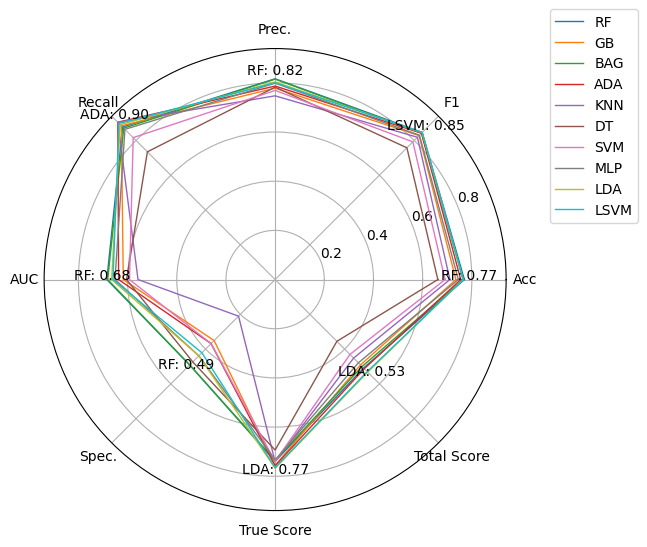

In [89]:
plot_radar_chart(pd.concat([ML_Scores['mitigated']['male'],TrueScores['mitigated']['male'], TotalScore['mitigated']['male']], axis=1))

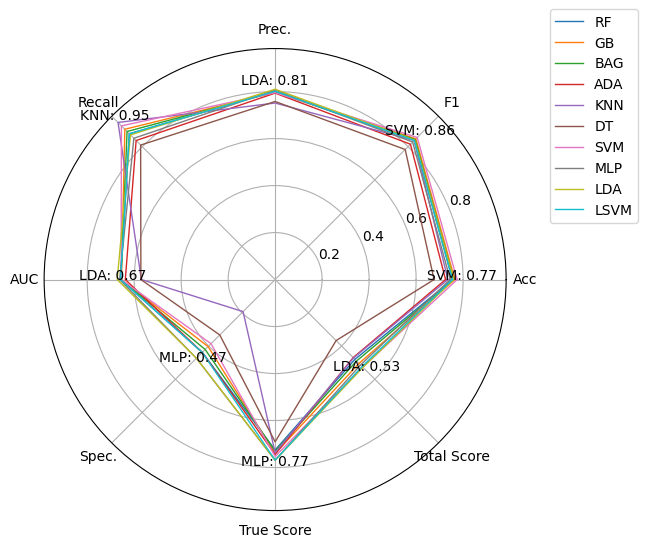

In [90]:
plot_radar_chart(pd.concat([ML_Scores['biased']['male'],TrueScores['biased']['male'], TotalScore['biased']['male']], axis=1))